In [1]:
#A code to fit create averaged 13CO line measurements from MIRI data (credits for MIRI processing to, in no order, Rob Gutermuth, Mayank Narang, Himanshu Tyagi)
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
import os
import sys

from astropy import units as u
from astropy.io import fits
import pandas as pd
from spectral_cube import SpectralCube

Mini part: Note down the apertures from NIRSpec so we can convert them to MIRI WCS

In [2]:
#set up file paths
protostars = ['IRAS16253', 'B335', 'HOPS153', '*370/HOPS370', 'IRAS20126']
protostar_fullnames = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104']
source_names_list = [['IRAS 16253-2429'], ['B335-W', 'B335-E'], ['HOPS 153-SE', 'HOPS 153-NW'], \
                     ['HOPS 370-S', 'HOPS 370-N'], ['IRAS 20126+4104-SE', 'IRAS 20126+4104-NW']]
miri_cube_file_list = [glob('MIRI/' + i + '*.fits')[0].replace("\\", "/") for i in protostars]

#the original data from nirspec
nirspec_cube_file_list = ['IRAS16253/jw01802-o015_t012_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'B335/jw01802-o003_t001_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS153/jw01802-o019_t015_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS370/jw01802-o007_t004_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'IRAS20126/jw01802-o011_t007_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits']

#source properties
from astropy.coordinates import SkyCoord
# WCS Centers for IRAS16253:  hms_tuple(h=16.0, m=28.0, s=21.62609704541552) -24d36m24.09648651s
# WCS Centers for B335:  hms_tuple(h=19.0, m=37.0, s=0.8699079677288069) 7d34m09.39280894s
# WCS Centers for B335:  hms_tuple(h=19.0, m=37.0, s=0.9237101166280581) 7d34m09.39280909s
# WCS Centers for B335:  hms_tuple(h=19.0, m=37.0, s=1.0380396908391276) 7d34m09.49280805s
# WCS Centers for HOPS153:  hms_tuple(h=5.0, m=37.0, s=57.0367543462649) -7d06m56.22624524s
# WCS Centers for HOPS153:  hms_tuple(h=5.0, m=37.0, s=56.989725483282) -7d06m55.32624524s
# WCS Centers for HOPS370:  hms_tuple(h=5.0, m=35.0, s=27.63610108344153) -5d09m34.85369136s
# WCS Centers for HOPS370:  hms_tuple(h=5.0, m=35.0, s=27.636101076407158) -5d09m34.05369135s
# WCS Centers for HOPS370:  hms_tuple(h=5.0, m=35.0, s=27.63610107113479) -5d09m33.45369134s
# WCS Centers for IRAS20126:  hms_tuple(h=20.0, m=14.0, s=26.06792206384) 41d13m32.34371041s
# WCS Centers for IRAS20126:  hms_tuple(h=20.0, m=14.0, s=25.943827882304618) 41d13m33.54370805s

source_coords_list = [[('16h28m21.62609704541552s', '-24d36m24.09648651s')], \
                        [('19h37m0.8699079677288069s', '7d34m9.39280894s'), ('19h37m0.9237101166280581s', '7d34m9.39280909s')], \
                        [('5h37m57.0367543462649s', '-7d6m56.22624524s'), ('5h37m56.989725483282s', '-7d6m55.32624524s')], \
                        [('5h35m27.63610108344153s', '-5d9m34.85369136s'), ('5h35m27.636101076407158s', '-5d9m34.05369135s')], \
                        [('20h14m26.06792206384s', '41d13m32.34371041s'), ('20h14m25.943827882304618s', '41d13m33.54370805s')]]

sky_coord_list = []
for i in source_coords_list:
    dummy_list = []
    for j in i:
        dummy_list.append(SkyCoord(j[0],j[1], frame='icrs'))
    sky_coord_list.append(dummy_list)

rect_theta = [0.0, 0.0, 50.0, 0.0, 35.0]
arc_to_pix = 3.61111097866e-05 * 3600.0 #take 1 pix in degrees from CDELT1 under the WCS parameters, convert to arcsec, then can divide by this to convert
aper_dims = [(0.51, 0.51), (0.68, 0.68), (0.53, 0.53), (0.67, 0.67), (0.49, 0.44)] #arcsecs

IndexError: list index out of range

In [ ]:
sky_coord_list

[[<SkyCoord (ICRS): (ra, dec) in deg
      (247.09010874, -24.60669347)>],
 [<SkyCoord (ICRS): (ra, dec) in deg
      (294.25362462, 7.56927578)>,
  <SkyCoord (ICRS): (ra, dec) in deg
      (294.25384879, 7.56927578)>],
 [<SkyCoord (ICRS): (ra, dec) in deg
      (84.48765314, -7.1156184)>,
  <SkyCoord (ICRS): (ra, dec) in deg
      (84.48745719, -7.1153684)>],
 [<SkyCoord (ICRS): (ra, dec) in deg
      (83.86515042, -5.15968158)>,
  <SkyCoord (ICRS): (ra, dec) in deg
      (83.86515042, -5.15945936)>],
 [<SkyCoord (ICRS): (ra, dec) in deg
      (303.60861634, 41.22565103)>,
  <SkyCoord (ICRS): (ra, dec) in deg
      (303.60809928, 41.22598436)>]]

In [ ]:
# ind = 4
# aper_dims[ind][1] * dist_list[ind] / pc_to_cm

# Part 0: Show images for reference

In [ ]:
#processing fits images of CO line emission to be saved...
#first define some lists to loop over for the different CO line series
# protostar_list = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
# protostar_names = ['IRAS 16253', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126'] #just to add some spaces
v_list = ['1*'] #, '3*']
j_list = ['P*']
pc_to_cm = 3.086e18
dist_list = pc_to_cm*np.array([140, 165, 390, 390, 1.55e3]) #pc: from Ortiz-Leon 2018, Watson 2020, Tobin+2020a, Tobin+2020a, Reid+2019

#some lists related to correcting for ices
transmission_folder = 'Ices/'
transmission_file_end = '_NIRspec_cube_pspline_asls_transmission.fits' 
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental, from cube fitting, needed to fix wavelengths we're using here

#a function to generate lists of co line intensity maps for our protostars
def co_data_output(protostar_str, v_str, j_str):
    #read in some protostellar images for each protostar
    co_file_list = sorted(glob('Line_Images/'+ protostar_str + '*_CO*v=' + v_str + j_str + '.fits'), key=lambda x: int(x.split('_')[-2][-2:]), reverse=True) #change the wildcard '*' here!; note we need the key to order images by number...

    #extract useful values and labels from file names in case of saving...
    #just using an example star to figure out general process (whatever is first), then loop later
    co_j =  [i.split('_')[-2][-2:] for i in co_file_list] 
    co_wavelengths = np.array([float(i.split('_')[-1][:-5]) for i in co_file_list])

    #setting up and correcting units
    hdul_co = [fits.open(j) for j in co_file_list]     #extract hdu files from paths
    sr_conversion = np.abs(hdul_co[0][0].header['CDELT1'] * hdul_co[0][0].header['CDELT2'] / (180. / np.pi)**2.0) #square degrees to steradians, should be consistent throughout all images (?)
    # mega_conversion = 1e6 #can swap out with Jy conversion to preferred units...
    co_data = [j[0].data*sr_conversion for j in hdul_co]     #extracting data for each hdu, converting units

    #reading in transmission file needed to slightly correct data
    # protostar_ind = protostars.index(protostar_str) #if you'd like to do this by indexing
    hdul_transmission = fits.open(transmission_folder + protostar_str + transmission_file_end) #read in hdu
    transmission_cube = SpectralCube.read(hdul_transmission[0]) #accessing the cube for data  
    co_header = transmission_cube[0].header #we need headers for later, but we can only take one slice (doesn't work if NAXIS > 2: https://github.com/aplpy/aplpy/issues/449)
    # jwst_wavelengths = transmission_cube.spectral_axis.value/1e-6 + offset_list[protostar_ind]
    # transmit_splined = interp1d(jwst_wavelengths, transmission_data, axis=0) #transmission data

    #correcting for ices by dividing them out as a transmission filter centered at the peak wavelength of each line
    # wave_cutoff_idx = np.where((co_wavelengths > 4.52)*(co_wavelengths < 4.96))[0]     #first spline the transmission curve, masking it where we want to apply it (wavelengths between 4.52 and 4.96)
    # co_data_corrected = [co_data[j] / transmit_splined_list[protostar_ind](co_wavelengths[j]) for j in wave_cutoff_idx] #then apply transmission curve
    # co_data_corrected = []
    # for i in range(len(co_wavelengths)): #making a brute force loop and condition since the mask wasn't working right
    #     if co_wavelengths[i] > 4.52 and co_wavelengths[i] < 4.96:
    #         co_data_corrected.append(co_data[i] / transmit_splined(co_wavelengths[i]))
    #     else:
    #         co_data_corrected.append(co_data[i])

    #applying smoothing or SNR cut (optional)
    # jwst_err_cube = hdul['ERR'].data #not using spectral cube here
    # err_flux1 = np.array(jwst_err_cube[:, ind1, ind2], dtype=np.float64)
    # flux1[ flux1/err_flux1 < 1] = 0
    # print(type(flux1[0])) #checking if float64

    return co_j, co_wavelengths, co_data, co_header #, co_data_corrected, transmit_splined

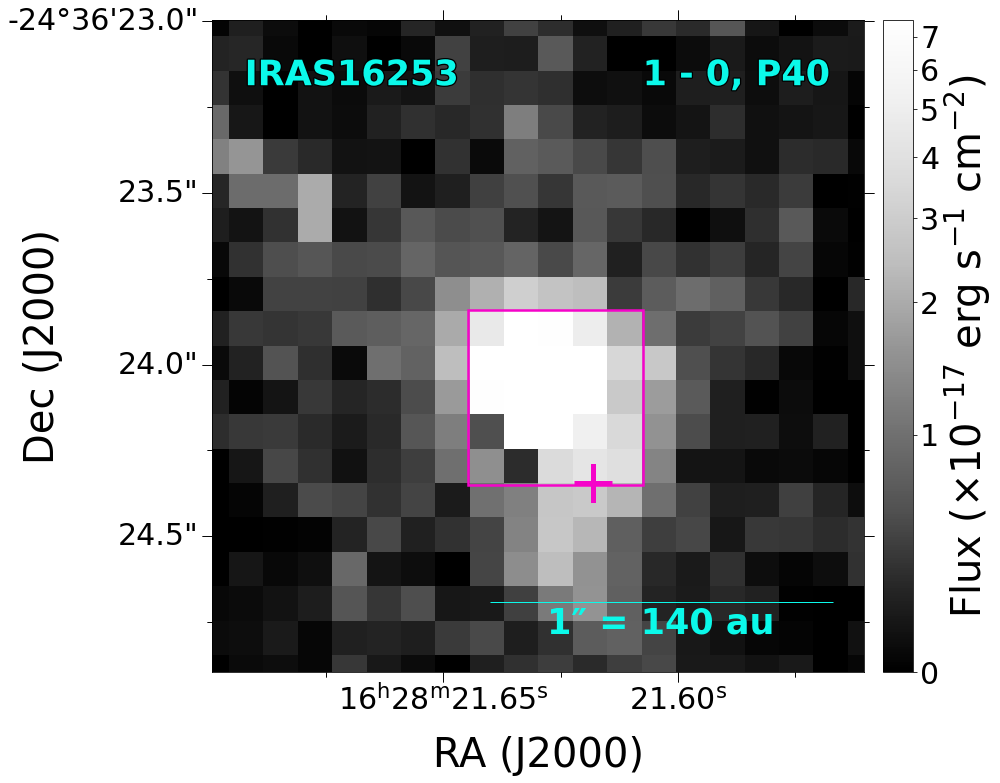

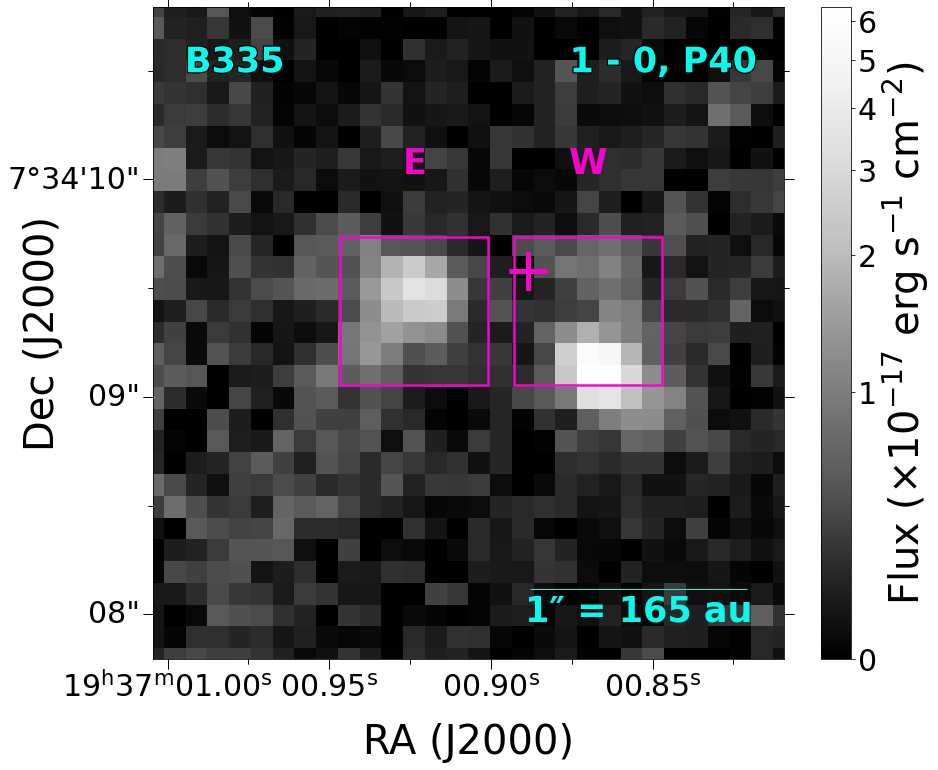

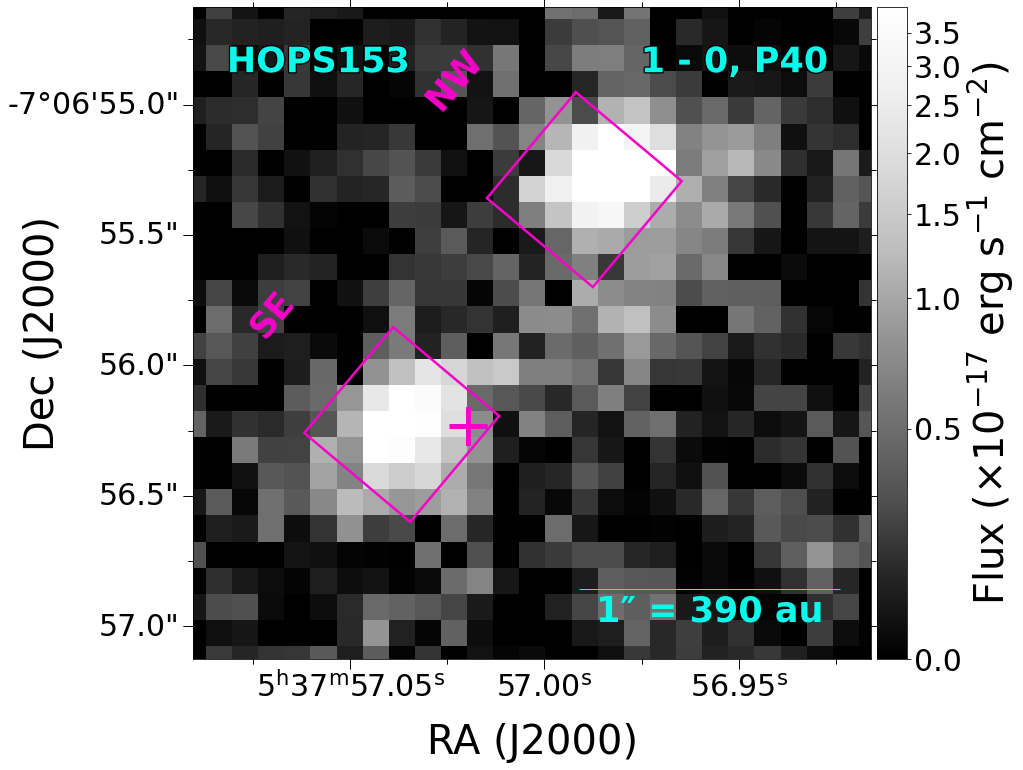

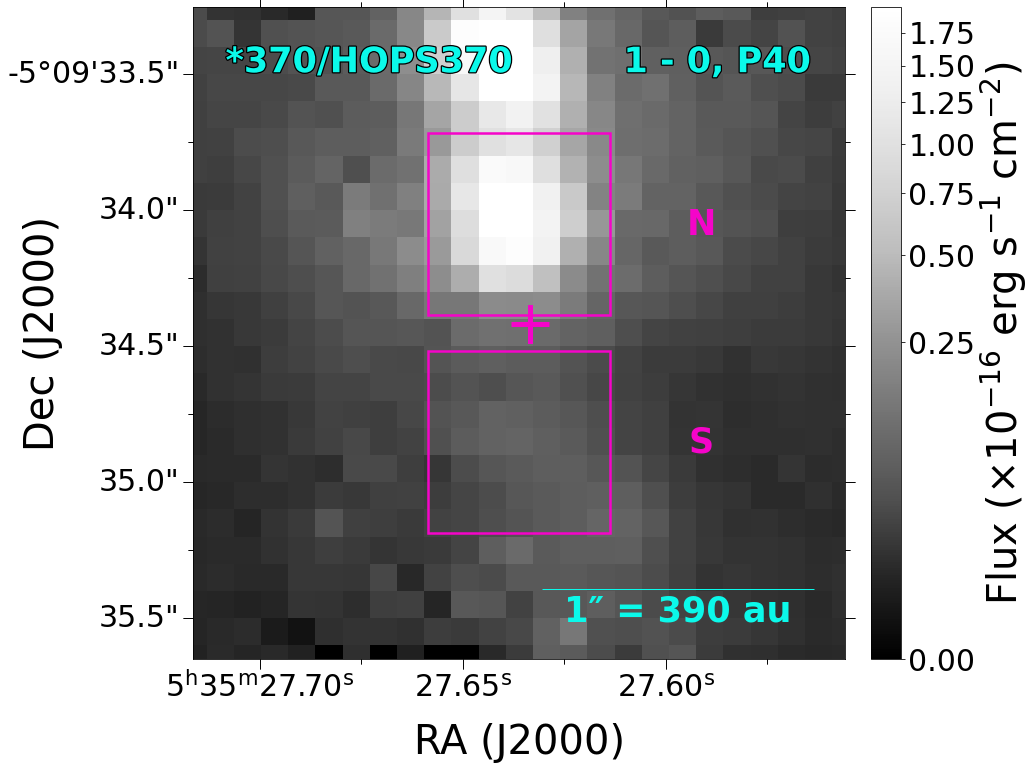

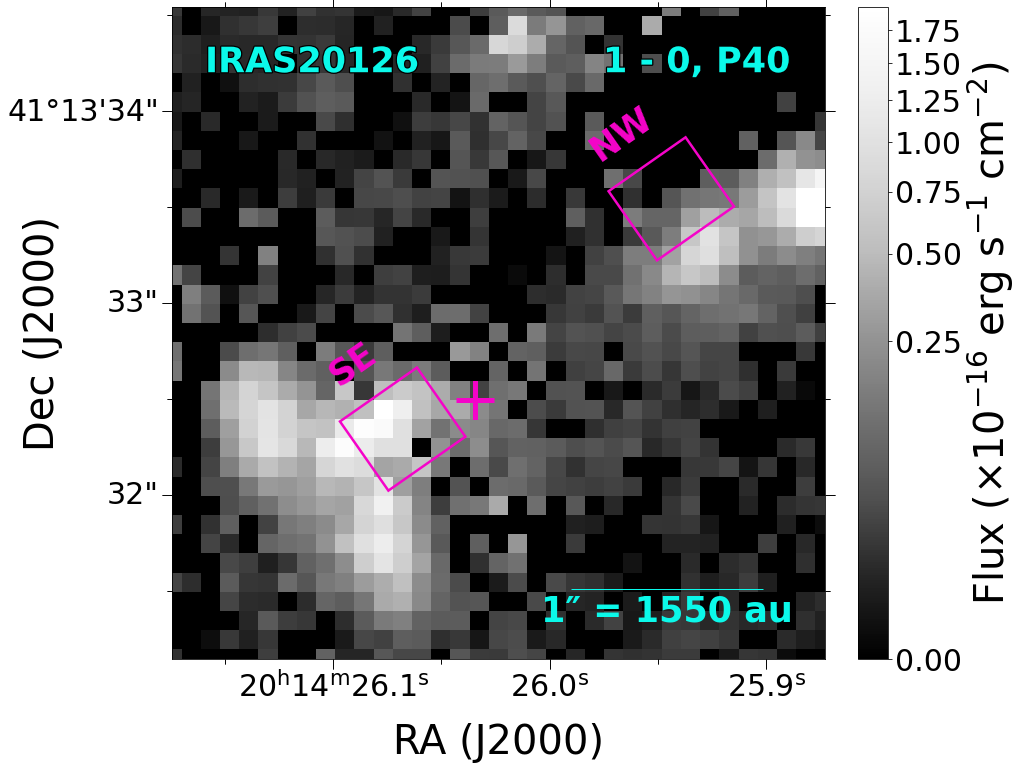

In [ ]:
#general imports for plotting images
from astropy.visualization.wcsaxes import add_scalebar
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, RectangularAperture #, RectangularAnnulus, SkyCircularAperture
import matplotlib.font_manager as fm
from matplotlib import patheffects
# import matplotlib.patches as patches 
# from matplotlib.transforms import Affine2D
# central_sources = [(45, 44), (46, 44), (44, 40), (39, 45), (46, 42)]
# central_sources = [(46,45), (44,43), (46, 48), (47, 45), (46, 43)] #location of sources in pixels
aper_shape_list = ['Rectangle', 'Rectangle', 'Rectangle', 'Rectangle', 'Rectangle']
# central_sources_list = [[(47,45)], [(53,43), (45,43), (28, 44)], [(42, 45), (49, 54)], [(42, 38), (42, 46), (42, 52)], [(42, 43), (58, 51)]] #based on line to cont ratio
# central_sources_list = [[(47,45)], [(53,43), (45,43)], [(42, 45), (49, 54)], [(42, 38), (42, 46)], [(42, 43), (58, 52)]] #based on line to cont ratio
arc_to_pix = 2.7777778191699e-05 * 3600.0 #take 1 pix in degrees, convert to arcsec, then can divide by this to convert
# aper_dims = [(0.51, 0.51), (0.68, 0.68), (0.53, 0.53), (0.67, 0.67), (0.49, 0.44)] #arcsecs
w_list = []
aperture_labels = [[''], ['W', 'E'], ['SE', 'NW'], ['S', 'N'], ['SE', 'NW']]
v_labels_list = ['1 - 0, P40']

#for image rescaling
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch, AsinhStretch, PowerStretch, SquaredStretch, SqrtStretch, SinhStretch, PercentileInterval
interval_choice_list = [[PercentileInterval(99.3)], [PercentileInterval(99)], [PercentileInterval(99.3)], [PercentileInterval(99.5)], \
                        [PercentileInterval(99.3)]] #set the interval we want to use
stretch_choice_list = [[AsinhStretch()], [AsinhStretch()], [AsinhStretch()], [PowerStretch(0.35)], [PowerStretch(0.35)]] # PowerStretch(0.3)
ax_xlims_list = [(37,56),(33,62),(34,60),(30,54),(31,65)]
ax_ylims_list = [(37,56),(27,57),(36,61),(30,54),(31,65)]

#optional, including list of RA and Dec from ALMA positions for reference
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5
#from NIRSpec, measuring the center by hand...
# photocen_ra_list = ['16h28m21.627s', '19h37m00.9s', '5h37m57.012s', '5h35m27.638s', '20h14m26.02s']
# photocen_dec_list = ['-24d36m24.08s', '+07d34m09.45s', '-7d06m55.775s', '-5d09m34.5s', '+41d13m32.75s']
#from MIRI 14 microns (ch 3 med), average (median); credit: Robert Gutermuth
# photocen_ra_list = ['16h28m21.63s', '19h37m00.93s', '5h37m57.03s', '5h35m27.64s', '20h14m26.04s']
# photocen_dec_list = ['-24d36m24.11s', '+07d34m09.32s', '-07d06m56.16s', '-05d09m33.94s', '+41d13m32.43s']
#from mm/sub-mm positions collected by Sam Federman
photocen_ra_list = ['16h28m21.62s', '19h37m00.89', '5h37m57.021', '5h35m27.635', '20h14m26.0364s']
photocen_dec_list = ['-24d36m24.33', '+07d34m09.6s', '-07d06m56.25s', '-05d09m34.44s', '+41d13m32.516s']

photocen_sky_list = [SkyCoord(i,j, frame=FK5) for i,j in zip(photocen_ra_list, photocen_dec_list)] #combining ra and dec to an astropy object
# offsets from alma ra: 0.012, 0.01, 0.09, 0.003, 0.0164
# offsets from alma dec: 0.25, 0.15, 0.475, 0.06, 0.234


#loop thorugh protostars:
for i in range(len(protostars)):
    #a control statement if you'd only like to test a single plot at a time without changing anything else
    # if protostars[i] != 'IRAS20126':
    #     continue


    #loop through the rotational states to collect a set of data and usable values
    #doing it by hand here since will only ever be two options
    # co_v_r_j, co_v_r_wavelengths, co_v_r_data, co_v_r_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[0], j_list[0])
    if protostars[i].find('*') == -1:
        co_v_p_j, co_v_p_wavelengths, co_v_p_data, co_header = co_data_output(protostars[i], v_list[0], j_list[0]) #, co_v_p_data_corrected, transmit_splined
    else:
        co_v_p_j, co_v_p_wavelengths, co_v_p_data, co_header = co_data_output('HOPS370', v_list[0], j_list[0]) #, co_v_p_data_corrected, transmit_splined

    # print(co_v_p_j[12], co_v_p_j[-8])
    # sys.exit()

    #need to first define a figure
    #code snippet to use header, convert to pixel values, reproject the plot to correct coordinates
    #need to define header to project onto correct coordinates
    fig = plt.figure(figsize=(52,12))     #defining figure to plot on 
    ax1 = fig.add_subplot(131, projection=WCS(co_header))
    ax_list = [ax1]
    w_list.append(WCS(co_header))

    #making an average of these data to produce images
    # sum_co_list = (np.nanmedian(co_v_r_data, axis=0) + np.nanmedian(co_v_p_data, axis=0))/2.0 #take average (median) for a representative example for each star
    # sum_co_list = np.nansum(co_v_r_data, axis=0) + np.nansum(co_v_p_data, axis=0) #take average (sum) for a representative example for each star

    #plotting example spaxel around center without many artifacts
    # image_size = co_v_p_data[10].shape #to correct position
    # ax_list[j].scatter(image_size[0] - central_sources[i][0], central_sources[i][1], marker='+', color='green', s=1500, linewidth=5) #if based on WCS coordinates

    #example image to check regions we're averaging over
    #this is the v=1 state done twice (once for high-J, once for low-J)

    #high-J (P40)
    norm = ImageNormalize(np.nan_to_num(co_v_p_data[12], posinf=0, neginf=0)[np.nan_to_num(co_v_p_data[12], posinf=0, neginf=0) > 0], interval=interval_choice_list[i][0], stretch=stretch_choice_list[i][0], vmin=0)
    im = ax_list[0].imshow(np.nan_to_num(co_v_p_data[12], posinf=0, neginf=0), cmap='Greys_r', norm=norm) # vmin=0, vmax=5*np.nanmean(co_v_p_data[12])) #plot image
    
    cax = fig.add_axes([ax_list[0].get_position().x1+0.005,ax_list[0].get_position().y0,0.008,ax_list[0].get_position().height])     #add on a color bar
    cbar = plt.colorbar(im, cax=cax) 
    cbar.ax.tick_params(labelsize=30)
    cbar.update_ticks()
    # exponent = int(np.floor(np.log10(co_v_p_data[protostar_ind][central_sources[protostar_ind][0], central_sources[protostar_ind][1]]))) #from a tip by https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
    exponent = int(np.floor(np.log10(np.median(np.nan_to_num(co_v_p_data[12], posinf=0, neginf=0)[np.nan_to_num(co_v_p_data[12], posinf=0, neginf=0) > 0])/10)))
    cbar.set_label(label='Flux (' + r'$\times 10^{{{0}}} \ $'.format(exponent) + r'$\rm erg \ s^{-1} \ {cm}^{-2})$', size=40)
    # cbar.ax.yaxis.get_offset_text().set_fontsize(0) #then use this text object to put in order of max...
    cbar.ax.yaxis.get_offset_text().set_visible(False) #better method


    #loop through vibrational states (each axis) for consistent formatting
    for j in range(len(ax_list)):
        #do some minor formatting here to label the image better
        add_scalebar(ax_list[j], 1*u.arcsec, corner='bottom right', color='xkcd:bright aqua', width=1e3, \
                    label=str(1) + u'\u2033' ' = ' + str(round(dist_list[i]*6.68459e-14 * 1.0 / 206265))+' au', fontproperties=fm.FontProperties(size=35, weight='bold')) #converting from cm to au, then 1/206265 to apply small angle formula
        ax_list[j].annotate(v_labels_list[j], xy = (0.66, 0.90), color='xkcd:bright aqua', fontsize=35, weight='bold', 
                                path_effects=[patheffects.withStroke(linewidth=2.5, foreground='black')] , xycoords='axes fraction') #note coords 0.73, 0.91 for upper right
        ax_list[j].annotate(protostars[i], xy = (0.05, 0.90), color='xkcd:bright aqua', fontsize=35, weight='bold', 
                                path_effects=[patheffects.withStroke(linewidth=2.5, foreground='black')] , xycoords='axes fraction') #for lower left, 0.05, 0.06
        
        #plot central source
        photocen_pix_list = WCS(co_header).world_to_pixel(photocen_sky_list[i]) #from sky to pixels for ease of plotting
        ax_list[j].scatter(photocen_pix_list[0], photocen_pix_list[1], marker='+', color='xkcd:hot magenta', s=1500, linewidth=5) #if based on pixel measurements on the images

        #overplotting the aperture
        # if aper_shape_list[i] == 'Circular':
        #     # circ_patch = patches.Circle((image_size[0] - central_sources[i][0], central_sources[i][1]), radius=0.5/arc_to_pix, linewidth=3.5, edgecolor='xkcd:cyan', facecolor='none', label=protostar_names[i]) #if baesd on WCS
        #     circ_aper = CircularAperture((central_sources_list[0], central_sources_list[1]), aper_dims[i]/arc_to_pix)
        #     aper_patch = circ_aper.plot(ax_list[j], linewidth=3.5, edgecolor='xkcd:hot magenta', facecolor='none')
        if aper_shape_list[i] == 'Rectangle':
            for k in range(len(sky_coord_list[i])):
                central_sources_list = sky_coord_list[i][k].to_pixel(w_list[i])

                #getting the box and plotting it with photutils
                central_sources_x, central_sources_y = central_sources_list
                # if i != 1 and k == 0:  #IRAS 16253 requires the i == 0 since it doesnt have more than one source in the source list
                #     ax_list[j].scatter(central_sources_x, central_sources_y, marker='+', color='xkcd:hot magenta', s=500, linewidth=4) #if based on pixel measurements on the images
                # elif i == 1 and k == 1:
                #         ax_list[j].scatter(central_sources_list[k][0], central_sources_list[k][1], marker='+', color='xkcd:hot magenta', s=750, linewidth=4.5) #if based on pixel measurements on the images                        
                rect_aper = RectangularAperture((central_sources_x, central_sources_y), aper_dims[i][0]/arc_to_pix, aper_dims[i][1]/arc_to_pix, theta=rect_theta[i]*np.pi/180)
                aper_patch = rect_aper.plot(ax_list[j], linewidth=2.5, edgecolor='xkcd:hot magenta', facecolor='none')

                #annotation: see https://stackoverflow.com/questions/14531346/how-to-add-a-text-into-a-rectangle
                rx, ry = aper_patch[0].get_xy()
                cx = aper_patch[0].get_width()/2.0
                cy = aper_patch[0].get_height()/2.0     
                if i == 1:           
                    ax_list[j].annotate(aperture_labels[i][k], (rx+cx, ry+3*cy), color='xkcd:hot magenta', weight='bold', fontsize=35, ha='center', va='center')
                if i == 2:           
                    ax_list[j].annotate(aperture_labels[i][k], (rx-cx-cx, ry+3*cy), color='xkcd:hot magenta', weight='bold', fontsize=35, ha='center', va='center', rotation=rect_theta[i])
                if i == 3:           
                    ax_list[j].annotate(aperture_labels[i][k], (rx+3*cx, ry+cy), color='xkcd:hot magenta', weight='bold', fontsize=35, ha='center', va='center')
                if i == 4:           
                    ax_list[j].annotate(aperture_labels[i][k], (rx-0.75*cx, ry+3*cy), color='xkcd:hot magenta', weight='bold', fontsize=35, ha='center', va='center', rotation=rect_theta[i])

    #formatting
    ax_list[j].tick_params(axis='x', labelsize=30)
    ax_list[j].tick_params(axis='y', labelsize=30)
    ax_list[j].coords[0].set_minor_frequency(2) #for minor ticks
    ax_list[j].coords[1].set_minor_frequency(2)
    ax_list[j].coords[0].display_minor_ticks(True)
    ax_list[j].coords[1].display_minor_ticks(True)
    ax_list[j].tick_params(axis='x', which='major', length=10)
    ax_list[j].tick_params(axis='y', which='major', length=10)
    ax_list[j].tick_params(axis='x', which='minor', length=5)
    ax_list[j].tick_params(axis='y', which='minor', length=5)
    ax_list[j].coords[0].set_axislabel('RA (J2000)', fontsize=40)
    ax_list[j].coords[1].set_axislabel('Dec (J2000)', fontsize=40, minpad=-0.9) 
    ax_list[j].set_xlim(ax_xlims_list[i][0], ax_xlims_list[i][1])
    ax_list[j].set_ylim(ax_ylims_list[i][0], ax_ylims_list[i][1])

    #display pixel coordinates that we used here for reference if curious
    # print([co_v_p_data_corrected[10][i].shape[0] - central_sources[i][0] for i in range(len(central_sources))], [i[1] for i in central_sources])

    # fig.savefig('CO_13_tests/' + protostars[i] + '_RefImage_for13CO.pdf') #save plot

# Part 1: Extract averaged spectra at high SNR (no need to overplot lines yet)

In [ ]:
#currently using P15 to P50
co_v1_lines = [4.897959679, 4.909119137, 4.920405435, 4.931819626, 4.943362768, 4.955035947, 4.966840267, 4.978776848, 4.990846834, 5.003051384, \
                5.015391683, 5.027868929, 5.040484354, 5.066134734, 5.07917225, 5.092353062, 5.105678503, \
                    5.119149935, 5.132768744, 5.146536333, 5.160454145, 5.174523632, 5.188746281, 5.203123603, 5.217657137, 5.232348453] # include when plotting: , 5.0532392
co_isotopologue_lines = [5.333388488, 5.318877235, 5.30451849, 5.29031078, 5.276252668, 5.26234273, 5.248579578, 5.234961839, 5.221488168, 5.208157241, 5.194967755, 5.181918437, \
    5.169008024, 5.15623528, 5.143598992, 5.131097968, 5.118731029, 5.106497024, 5.094394818, 5.082423295, 5.070581362, 5.058867934, 5.047281958, 5.035822391, \
    5.024488207, 5.013278402, 5.002191988, 4.991227989, 4.980385452, 4.969663437, 4.95906102, 4.948577297, 4.938211373, 4.927962373, 4.917829436, 4.907811716]
co_v2_lines = [5.227636799, 5.213449873, 5.19941707, 5.185536908, 5.171807925, 5.158228694, 5.144797803, 5.131513876, \
               5.11837555, 5.105381494, 5.092530394, 5.079820964, 5.067251937, 5.054822073, 5.042530141, 5.030374953, \
                5.018355322, 5.006470094, 4.994718123, 4.983098297, 4.971609517, 4.960250699, 4.949020785, 4.93791873, \
                    4.926943518, 4.916094136, 4.905369598]
co_v3_lines = [5.14575249, 5.13294783, 5.120285863, 5.107765329, 5.09538499, 5.083143628, 5.07104004, 5.059073053, \
               5.047241514, 5.035544283, 5.023980249, 5.012548316, 5.001247406, 4.990076467, 4.979034458, 4.968120359, \
                4.957333173, 4.946671911, 4.936135614, 4.925723328, 4.915434127]

C:\Users\arubi\AppData\Local\Temp\ipykernel_35400\3175584868.py:158: RuntimeWarning: invalid value encountered in double_scalars
  miri_centroid = np.sum(miri_wave_masked[miri_min:miri_max] * avg_norm_miri[miri_min:miri_max]) / np.sum(avg_norm_miri[miri_min:miri_max])
C:\Users\arubi\AppData\Local\Temp\ipykernel_35400\3175584868.py:166: RuntimeWarning: invalid value encountered in double_scalars
  miri_centroid_err =  1.0/np.sqrt(ind_width*2) * np.sqrt(np.sum((miri_wave_masked[miri_min:miri_max] - miri_centroid)**2 * avg_norm_miri[miri_min:miri_max]) \
C:\Users\arubi\AppData\Local\Temp\ipykernel_35400\3175584868.py:158: RuntimeWarning: invalid value encountered in double_scalars
  miri_centroid = np.sum(miri_wave_masked[miri_min:miri_max] * avg_norm_miri[miri_min:miri_max]) / np.sum(avg_norm_miri[miri_min:miri_max])
C:\Users\arubi\AppData\Local\Temp\ipykernel_35400\3175584868.py:166: RuntimeWarning: invalid value encountered in double_scalars
  miri_centroid_err =  1.0/np.sqrt(ind_width

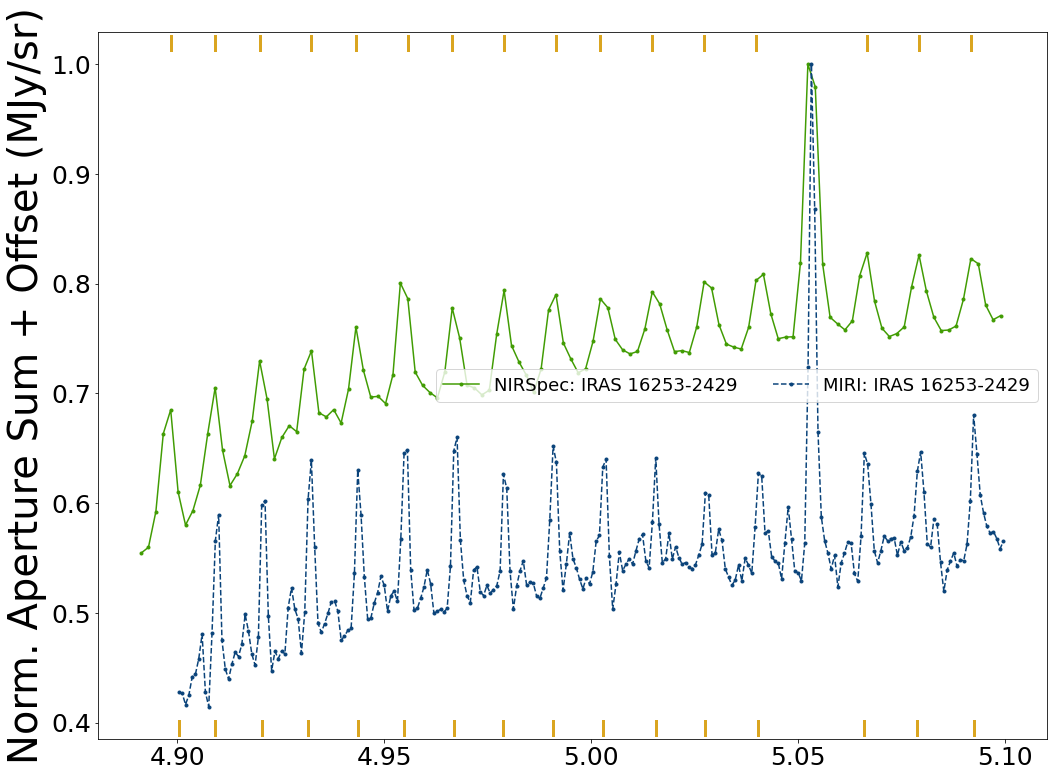

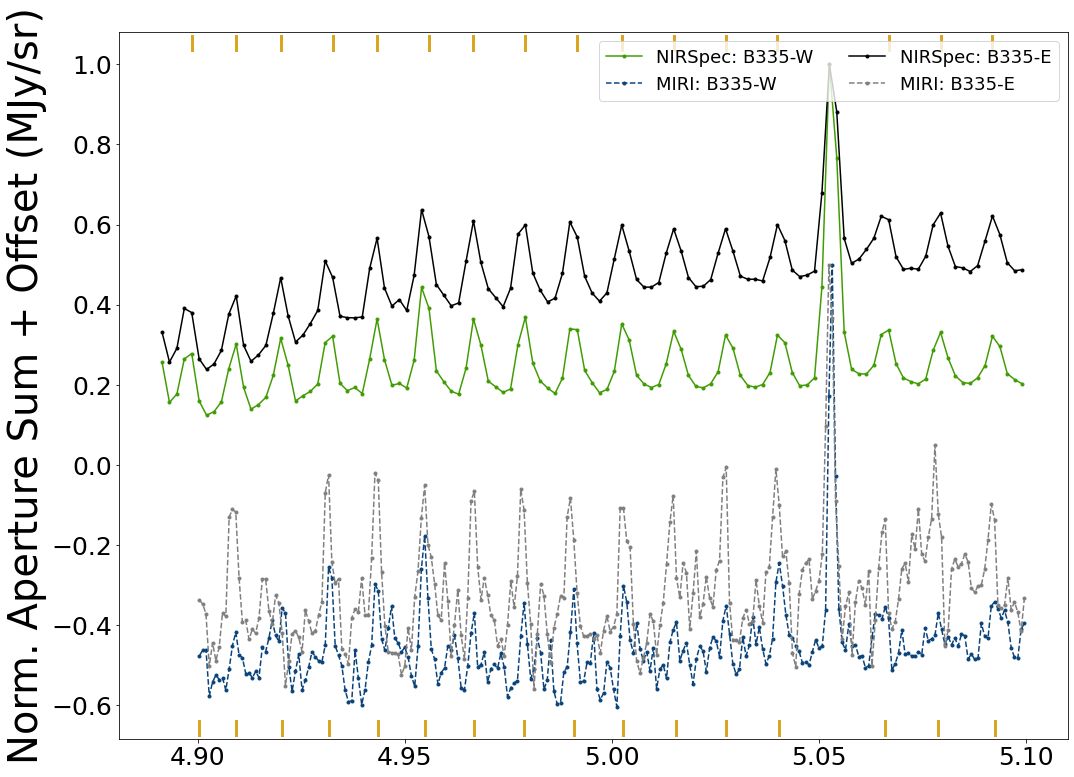

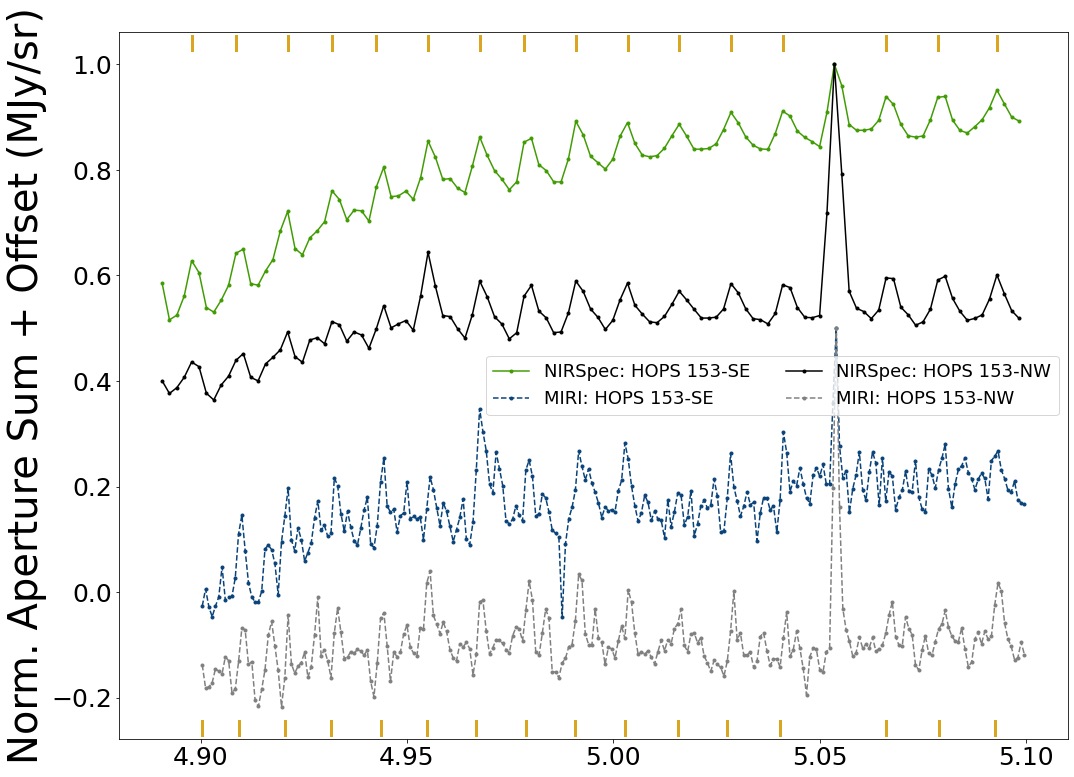

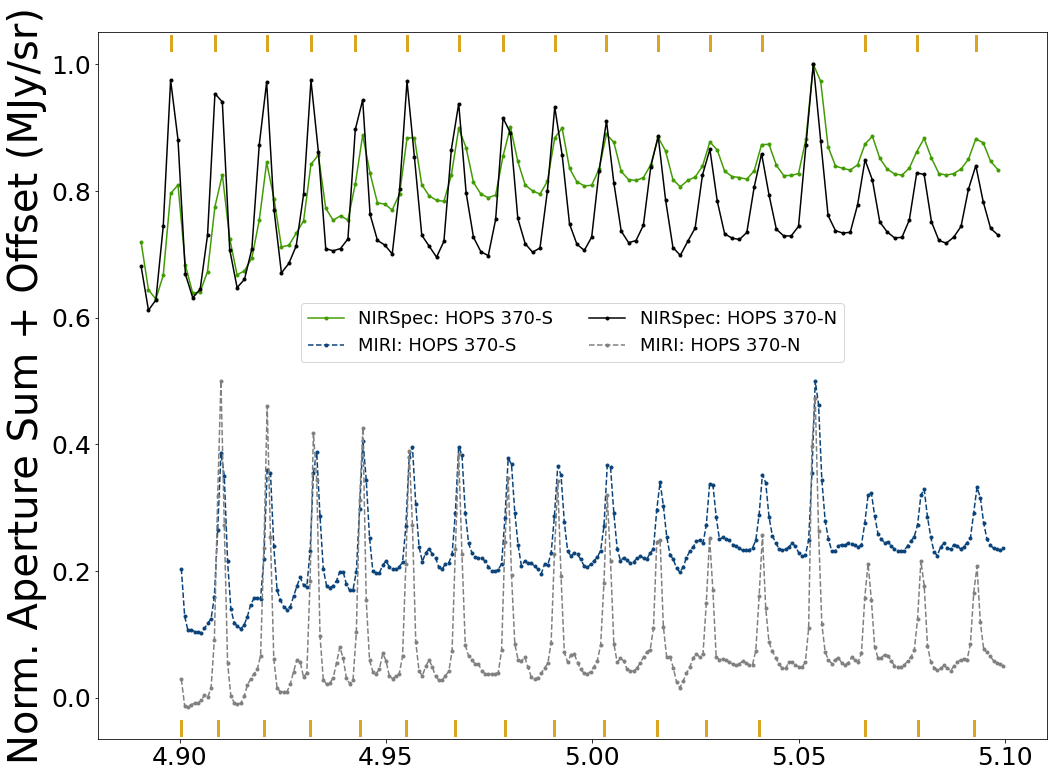

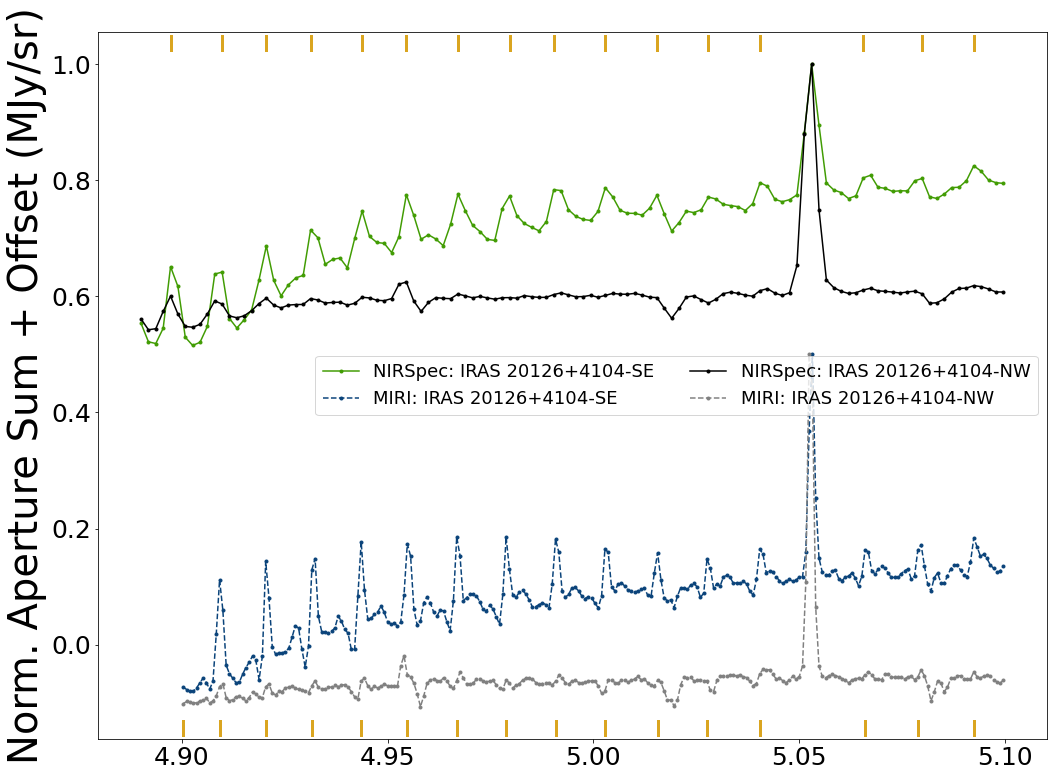

In [71]:
#plotting test spectra here
from photutils.aperture import SkyRectangularAperture, SkyCircularAperture #, RectangularAnnulus, 
from astropy.wcs import WCS
# from scipy.signal import find_peaks

#data processing needs
average = 'sum' # pick median or sum for picking which one we want
wavelength_lims = (4.89, 5.1)
# threshold_list = [0.001, 0.001, 0.001, 0.001, 0.001]
co_v1_lines_filtered = np.array([i for i in co_v1_lines if i > wavelength_lims[0] and i < wavelength_lims[1]]) #filter to be within wavelength lims
ind_width = 2

#generic need to store data for later
miri_line_centroids = []
nirspec_line_centroids = []
miri_centroids_err_list = []
nirspec_centroids_err_list = []

#plot formatting needs
nirspec_colors = [('xkcd:grassy green', 'black'), ('xkcd:grassy green', 'black'), ('xkcd:grassy green', 'black'), ('xkcd:grassy green', 'black'), ('xkcd:grassy green', 'black')] #first aperture then second
miri_colors = [('xkcd:twilight blue', 'gray'), ('xkcd:twilight blue', 'gray'), ('xkcd:twilight blue', 'gray'), ('xkcd:twilight blue', 'gray'), ('xkcd:twilight blue', 'gray')]
# ylim_list = [(5e3, 1.1e4), (-7.5e2, 1.75e3), (1e3, 6.5e3), (0.5e6, 1.2e6), (1e5, 4e5)] #min then max
ls_list = ['-', '--']
# y_offset_list = [[(0,3e3)], [(0,-500),(0,-500)], [(0,0),(1000,0)], [(0.95e6,0.5e6),(0,0)], [(0,0), (1e5,1e5)]] #first aperture of nirspec then miri, then same for second aperture
y_offset_list = [[(0,0)], [(0,-0.5),(0, -0.5)], [(0,-0.5),(0,-0.5)], [(0,-0.5),(0,-0.5)], [(0,-0.5), (0,-0.5)]] #first aperture of nirspec then miri, then same for second aperture


#loop through, read in data files, extract data at single pixel, plot
for i in range(len(protostars)):
    fig, ax = plt.subplots(figsize=(17,13)) #setup fig, axes for EACH PROTOSTAR

    #grouping per source
    dummy_list_miri = [] #used for centroiding
    dummy_list_nirspec = [] #used for centroiding
    dummy_list_err_miri = [] #used for centroiding ERR
    dummy_list_err_nirspec = [] #used for centroiding ERR

    for k in range(len(source_names_list[i])): #for each source...
        source = source_names_list[i][k] #define name using indices

        #read in original data FOR MIRI
        miri_hdul = fits.open(miri_cube_file_list[i]) #separated out line here since need to use miri_hdul a few times
        miri_orig_cube = SpectralCube.read(miri_hdul[1]) #accessing the cube for data  
        miri_err_data = miri_hdul['ERR'].data #needed for chi^2

        #before getting a slab with an aperture, we want to use the aperture to define a mask
        if aper_shape_list[i] == 'Rectangle':
            aper_cut = SkyRectangularAperture(sky_coord_list[i][k], aper_dims[i][0]*u.arcsec, aper_dims[i][1]*u.arcsec, theta=rect_theta[i]*u.deg) #using sky coords
        elif aper_shape_list[i] == 'Circular':
            aper_cut = SkyCircularAperture(sky_coord_list[i][k], aper_dims[i]*u.arcsec) #using sky coords
        wcs_header = WCS(miri_orig_cube.header).dropaxis(2) #dropping the wavelength axis in this wcs to only account for spatial transformation
        rect_mask = aper_cut.to_pixel(wcs_header).to_mask() #converting to a spatial mask

        #extracting slab
        data_list = [] #dummy list
        for data_2d in miri_orig_cube._data[:,:,:]: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        miri_orig_slab = np.array(data_list) #need to invoke original cutoff...but as a slab this time
        #and errors in fluxes
        err_list = [] #dummy list
        for data_2d in miri_err_data: #loop through data to mask properly
            err_list.append(rect_mask.cutout(data_2d))
        miri_err_slab = np.array(err_list) #need to invoke original cutoff...but as a slab this time

        #REPEAT AGAIN for NIRSpec
        #read in original data
        nirspec_hdul = fits.open(nirspec_cube_file_list[i]) #separated out line here since need to use nirspec_hdul a few times
        nirspec_orig_cube = SpectralCube.read(nirspec_hdul[1]) #accessing the cube for data  
        nirspec_err_data = nirspec_hdul['ERR'].data #needed for chi^2...converting to torch 

        #before getting a slab with an aperture, we want to use the aperture to define a mask
        if aper_shape_list[i] == 'Rectangle':
            aper_cut = SkyRectangularAperture(sky_coord_list[i][k], aper_dims[i][0]*u.arcsec, aper_dims[i][1]*u.arcsec, theta=rect_theta[i]*u.deg) #using sky coords
        elif aper_shape_list[i] == 'Circular':
            aper_cut = SkyCircularAperture(sky_coord_list[i][k], aper_dims[i]*u.arcsec) #using sky coords
        wcs_header = WCS(nirspec_orig_cube.header).dropaxis(2) #dropping the wavelength axis in this wcs to only account for spatial transformation
        rect_mask = aper_cut.to_pixel(wcs_header).to_mask() #converting to a spatial mask

        #extracting slab
        data_list = [] #dummy list
        for data_2d in nirspec_orig_cube._data[:,:,:]: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        nirspec_orig_slab = np.array(data_list) #need to invoke original cutoff...but as a slab this time
        #and errors in fluxes
        err_list = [] #dummy list
        for data_2d in nirspec_err_data: #loop through data to mask properly
            err_list.append(rect_mask.cutout(data_2d))
        nirspec_err_slab = np.array(err_list) #need to invoke original cutoff...but as a slab this time


        # define the wavelength grid (microns) from the header
        # wave_offset = offset_list[i] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
        # wave_factor = 1 #/1.001 #for wavelength calibrating
        # wave_units = 1 #1e6 #to convert from meters to microns, for original data just set to 1
        # wave = wave_factor * wave_units * miri_orig_cube.spectral_axis.value #+ wave_offset
        # wave = wave[1:-1] #need to make correct axis size
        miri_wave = miri_orig_cube.spectral_axis.value #+ wave_offset
        nirspec_wave = nirspec_orig_cube.spectral_axis.value #+ wave_offset

        #plotting to compare the bright v=1 CO lines to the weak CO lines possible in the residuals (checking for overlaps with 13CO or non-overlaps with v>1)
        #do some averages and plot
        if average == 'median':
            avg_miri_orig_slab = np.nanmedian(miri_orig_slab, axis=(1,2))
            avg_nirspec_orig_slab = np.nanmedian(nirspec_orig_slab, axis=(1,2))
            avg_miri_err = np.nanmedian(miri_err_slab, axis=(1,2))
            avg_nirspec_err = np.nanmedian(nirspec_err_slab, axis=(1,2))
        elif average == 'sum':
            avg_miri_orig_slab = np.nansum(miri_orig_slab, axis=(1,2))
            avg_nirspec_orig_slab = np.nansum(nirspec_orig_slab, axis=(1,2))
            avg_miri_err = np.nansum(miri_err_slab, axis=(1,2))
            avg_nirspec_err = np.nansum(nirspec_err_slab, axis=(1,2))

        #normalize and mask the spectra
        #first masking
        miri_mask = (miri_wave > wavelength_lims[0]) & (miri_wave < wavelength_lims[1]) #miri
        avg_miri_slab_masked = avg_miri_orig_slab[miri_mask] #data
        avg_miri_err_masked = avg_miri_err[miri_mask] #err
        miri_wave_masked = miri_wave[miri_mask] #wavelengths
        nirspec_mask = (nirspec_wave > wavelength_lims[0]) & (nirspec_wave < wavelength_lims[1]) #nirspec
        avg_nirspec_slab_masked = avg_nirspec_orig_slab[nirspec_mask] #data
        avg_nirspec_err_masked = avg_nirspec_err[nirspec_mask] #err
        nirspec_wave_masked = nirspec_wave[nirspec_mask] #wavelengths
        #hten normalizing 
        avg_norm_miri = avg_miri_slab_masked / np.max(avg_miri_slab_masked) #miri data
        avg_norm_nirspec = avg_nirspec_slab_masked / np.max(avg_nirspec_slab_masked) #nirspec data
        avg_err_norm_miri = avg_miri_err_masked / np.max(avg_miri_slab_masked) #miri err
        avg_err_norm_nirspec = avg_nirspec_err_masked / np.max(avg_nirspec_slab_masked) #nirspec err

        #determine a mask of dataset from wavelength limits and then plotting the masked spectra
        ax.plot(nirspec_wave_masked, avg_norm_nirspec  + y_offset_list[i][k][0], marker='o', markersize=3, color=nirspec_colors[i][k], ls=ls_list[0], label='NIRSpec: ' + source) #plotting curves; for offseting
        ax.plot(miri_wave_masked, avg_norm_miri  + y_offset_list[i][k][1], marker='o', markersize=3, color=miri_colors[i][k], ls=ls_list[1], label='MIRI: ' + source) #plotting curves; for offsetting:

        # #now find peaks within the subset given a threshold...then plotting them
        #for now, we simply take the reference wavelengths for each line ~v=1-0 P20 and go off that
        miri_line_matches = [] #wavelengths
        nirspec_line_matches = [] #wavelengths
        dummy_list_miri_aperture = [] #data
        dummy_list_nirspec_aperture = [] #data
        dummy_err_miri_aperture = [] #ERR
        dummy_err_nirspec_aperture = [] #ERR
        for line in co_v1_lines_filtered:
            #first find the matching index where the lines are in wavelength space (need to do separately per instrument)
            miri_matching_ind = np.argmin(np.abs(miri_wave_masked - line))
            miri_line_matches.append(miri_matching_ind)
            nirspec_matching_ind = np.argmin(np.abs(nirspec_wave_masked - line))
            nirspec_line_matches.append(nirspec_matching_ind)

            #next we can actually match peaks and determine centroids given the matching indices 
            #let's naively assume these wavelengths match the peaks perfectly and go from there...we normalized, so everything should be positive!
            miri_halfmax = avg_norm_miri[miri_matching_ind] / 2 # we can compute this for ref eventually for fwhm, but at this resolution, usually it's just +/- 1 spectral element...
            miri_min = miri_matching_ind - ind_width # np.argmin(np.abs(avg_norm_miri - miri_halfmax))[0]
            miri_max = miri_matching_ind + ind_width # np.argmin(np.abs(avg_norm_miri - miri_halfmax))[1]
            nirspec_halfmax = avg_norm_nirspec[nirspec_matching_ind] / 2
            nirspec_min = nirspec_matching_ind - ind_width # np.argmin(np.abs(avg_norm_nirspec - nirspec_halfmax))[0]
            nirspec_max = nirspec_matching_ind + ind_width # np.argmin(np.abs(avg_norm_nirspec - nirspec_halfmax))[1]

            #now can go onto centroiding, which is generally the sum of xi * yi divided by the sum of yi when looking for the position x_centroid
            miri_centroid = np.sum(miri_wave_masked[miri_min:miri_max] * avg_norm_miri[miri_min:miri_max]) / np.sum(avg_norm_miri[miri_min:miri_max])
            nirspec_centroid = np.sum(nirspec_wave_masked[nirspec_min:nirspec_max] * avg_norm_nirspec[nirspec_min:nirspec_max]) / np.sum(avg_norm_nirspec[nirspec_min:nirspec_max])

            #propagating uncertainties in normalized flux ERR
            #so this will be basically aA + bB + ... -> sqrt(a^2*sigA^2 + b^2*sigB^2 ...) NEGLECTING COVARIANCE!...
            # miri_centroid_err =  np.sum(miri_wave_masked[miri_min:miri_max] * avg_err_norm_miri[miri_min:miri_max]) / np.sum(avg_err_norm_miri[miri_min:miri_max])
            # nirspec_centroid_err =  np.sum(nirspec_wave_masked[nirspec_min:nirspec_max] * avg_err_norm_nirspec[nirspec_min:nirspec_max]) / np.sum(avg_err_norm_nirspec[nirspec_min:nirspec_max])
            #alternatively, we can compute the weighted average about the mean, which is delta_x = 1/sqrt(N-1) * sqrt(sum[(xi - xmean)^2 * wi] / sum(wi))
            miri_centroid_err =  1.0/np.sqrt(ind_width*2) * np.sqrt(np.sum((miri_wave_masked[miri_min:miri_max] - miri_centroid)**2 * avg_norm_miri[miri_min:miri_max]) \
                                                                     / np.sum(avg_norm_miri[miri_min:miri_max]))
            nirspec_centroid_err =  1.0/np.sqrt(ind_width*2) * np.sqrt(np.sum((nirspec_wave_masked[nirspec_min:nirspec_max] - nirspec_centroid)**2 * avg_norm_nirspec[nirspec_min:nirspec_max]) \
                                                                        / np.sum(avg_norm_nirspec[nirspec_min:nirspec_max]))

            #checking the peak and halfmax values as well as the wavelength min and max; finally checking the centroids
            # print(avg_norm_miri[miri_matching_ind], miri_halfmax, miri_min, miri_max, miri_centroid)
            # print(avg_norm_nirspec[nirspec_matching_ind], nirspec_halfmax, nirspec_min, nirspec_max, nirspec_centroid)

            #using these lists to store each individual centroid (per LINE)
            dummy_list_miri_aperture.append(miri_centroid)
            dummy_list_nirspec_aperture.append(nirspec_centroid)
            dummy_err_miri_aperture.append(miri_centroid_err) #ERR
            dummy_err_nirspec_aperture.append(nirspec_centroid_err) #ERR

        #append the LIST of centroids (per APERTURE) to our dummy lists
        dummy_list_miri.append(dummy_list_miri_aperture)
        dummy_list_nirspec.append(dummy_list_nirspec_aperture)
        dummy_list_err_miri.append(dummy_err_miri_aperture)
        dummy_list_err_nirspec.append(dummy_err_nirspec_aperture)

        #then need to take the indices and notate the peaks with them for reference
        #for the miri spectra, display lines at bottom, for nirspec spectra, display lines at top
        nirspec_line_matches = np.array(nirspec_line_matches)         #reformatting for ease
        for ind2 in nirspec_line_matches:
            ax.axvline(nirspec_wave_masked[ind2], ymin=0.975, ymax=0.995, color='goldenrod', ls='-', lw=3) # nirspec_colors[i][k]
        miri_line_matches = np.array(miri_line_matches)         #reformatting for ease
        for ind1 in miri_line_matches:
            ax.axvline(miri_wave_masked[ind1], ymin=0.005, ymax=0.025, color='goldenrod', ls='-', lw=3) # miri_colors[i][k]


    #storing each list for later grouped per *SOURCE*
    miri_line_centroids.append([dummy_list_miri]) #for later
    nirspec_line_centroids.append([dummy_list_nirspec]) #for later
    miri_centroids_err_list.append([dummy_list_err_miri])
    nirspec_centroids_err_list.append([dummy_list_err_nirspec])

    # ax.set_ylim(np.min(avg_orig_slab[:wave_max_ind])/2, np.max(avg_orig_slab[:wave_max_ind])*1.1)
    # ax.set_yscale('log')
    # ax.set_ylim(ylim_list[i][0], ylim_list[i][1])
    ax.set_ylabel('Norm. Aperture Sum + Offset (MJy/sr)', fontsize=40)
    # ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40) #need to set the xlabel here first
    if i != 3:
        ax.legend(loc='best', fontsize=18, ncol=2)
    else:
        ax.legend(loc='center', fontsize=18, ncol=2, bbox_to_anchor=(0.5,0.575))
    # ax.set_xlim(wavelength_lims[0], wavelength_lims[1]) #fix the wavelength to be between the best lines we know of
    ax.tick_params(axis='both', which='major', labelsize=25) #only need to do formatting once

    fig.savefig('CentralSource_CO/' + source + '_nirspec_miri_comparison.pdf', bbox_inches='tight')

    # sys.exit()

# take computed centroids and plot the potential shifts for each protostar

B335 23.5 18.5 7.5 4.2
HOPS 153 -0.8 1.9 -1.4 1.9
HOPS 370 -4.7 1.5 -2.4 2.5
IRAS 20126+4104 3.0 1.7 3.0 1.6


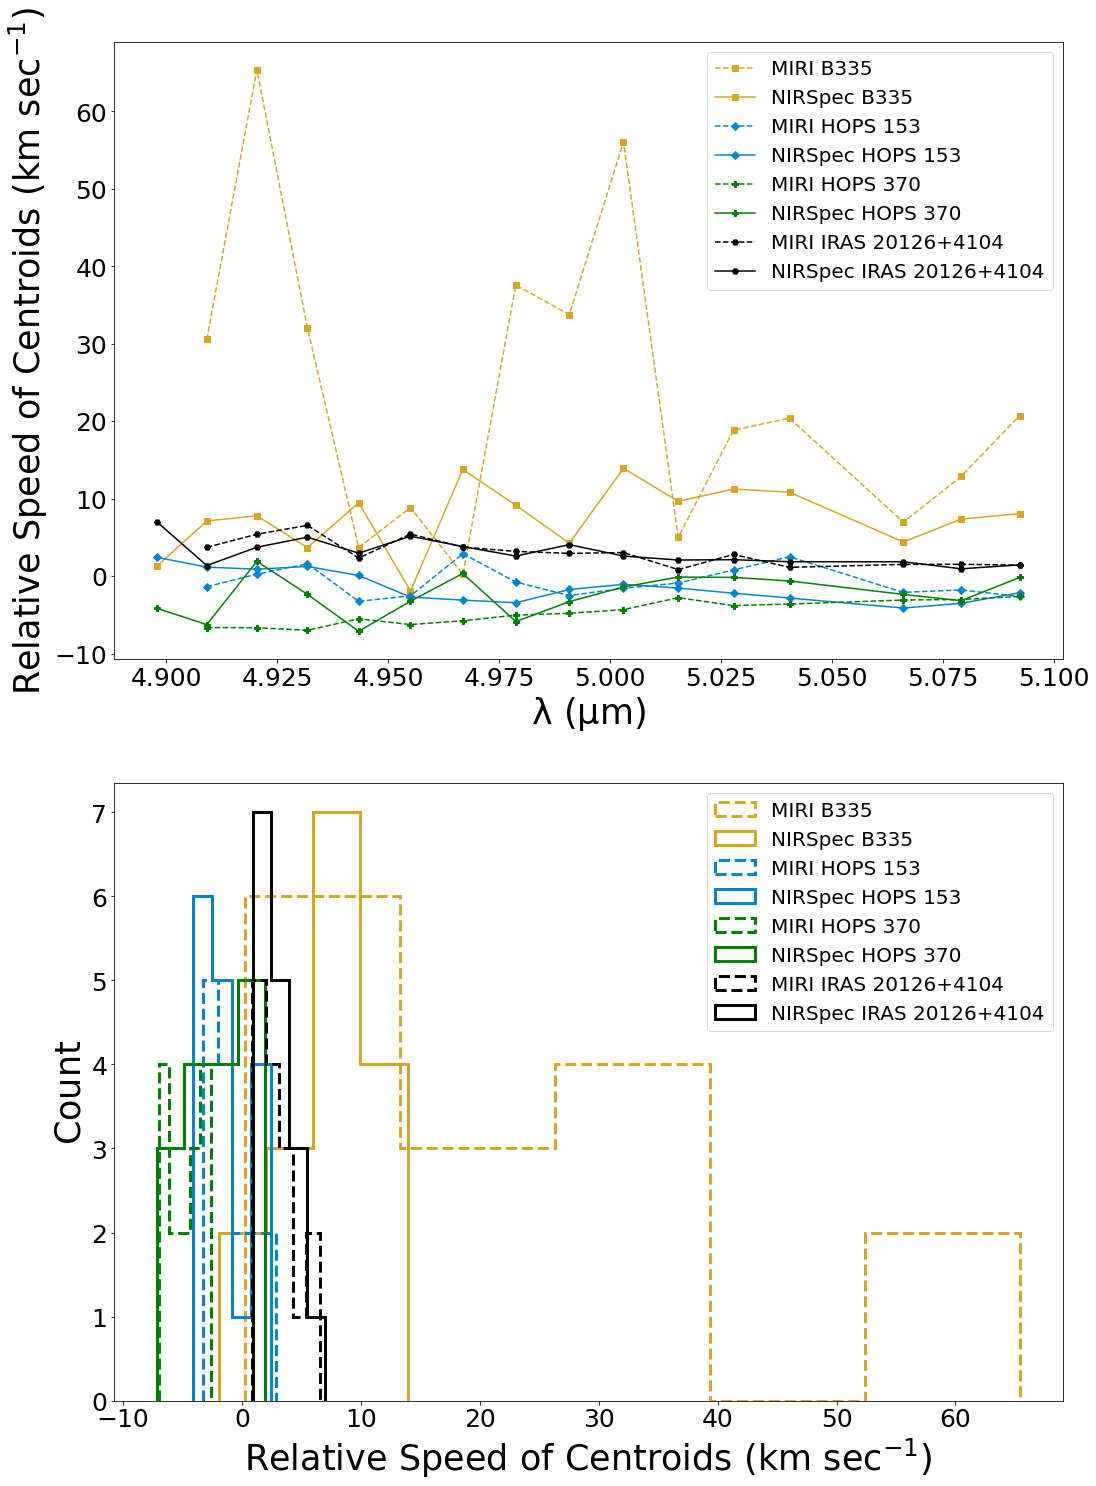

In [72]:
#for plotting need to distinguish each protostar
fig, (ax_spectrum, ax_hist) = plt.subplots(figsize=(17,25), nrows=2) #setup fig, axes for EACH PROTOSTAR
color_list = ['xkcd:brick red', 'goldenrod', 'xkcd:cerulean', 'green', 'black'] #other params
shape_list = ['o', 's', 'D', 'P', 'H']

for i in [1,2,3,4]: #skip iras 16253 here since we don't have enough data
    #making indexing explicitly since only dealing with two apertures here
    miri_aperture1_centroids = np.array(miri_line_centroids[i][0][0])
    miri_aperture2_centroids = np.array(miri_line_centroids[i][0][1] )
    nirspec_aperture1_centroids = np.array(nirspec_line_centroids[i][0][0])
    nirspec_aperture2_centroids = np.array(nirspec_line_centroids[i][0][1])

    #now grabbing error values
    miri_aperture1_centroids_ERR = np.array(miri_centroids_err_list[i][0][0])
    miri_aperture2_centroids_ERR = np.array(miri_centroids_err_list[i][0][1] )
    nirspec_aperture1_centroids_ERR = np.array(nirspec_centroids_err_list[i][0][0])
    nirspec_aperture2_centroids_ERR = np.array(nirspec_centroids_err_list[i][0][1])

    #computing difference in centroids
    miri_diffs = miri_aperture1_centroids - miri_aperture2_centroids
    nirspec_diffs = nirspec_aperture1_centroids - nirspec_aperture2_centroids
    miri_diffs_ERR = np.sqrt(miri_aperture1_centroids_ERR**2.0 + miri_aperture2_centroids_ERR**2.0) #just propagated as sum of squares
    nirspec_diffs_ERR = np.sqrt(nirspec_aperture1_centroids_ERR**2.0 + nirspec_aperture2_centroids_ERR**2.0) #just propagated as sum of squares

    #computing speeds from centroids 
    #the speed will be v/c = delta_lambda / lambda, so v = c * delta_lambda/lambda, where c = 3e5 km/sec as long as the wavelengths are same units (they are)
    miri_speeds = 3e5 * miri_diffs / co_v1_lines_filtered
    nirspec_speeds = 3e5 * nirspec_diffs / co_v1_lines_filtered
    miri_speeds_ERR = 3e5 * miri_diffs_ERR / co_v1_lines_filtered #propagation goes by scaling factor...
    nirspec_speeds_ERR = 3e5 * nirspec_diffs_ERR / co_v1_lines_filtered

    print(protostar_fullnames[i], round(np.nanmean(miri_speeds),1), round(np.nanstd(miri_speeds),1), round(np.nanmean(nirspec_speeds),1), round(np.nanstd(nirspec_speeds),1))

    #now we can plot! as function of wavelength:
    # if i != 1:
    ax_spectrum.plot(co_v1_lines_filtered, miri_speeds, color=color_list[i], marker=shape_list[i], label='MIRI ' + protostar_fullnames[i], linestyle='--')
    ax_spectrum.plot(co_v1_lines_filtered, nirspec_speeds, color=color_list[i], marker=shape_list[i], label='NIRSpec ' + protostar_fullnames[i])
    # elif i == 1:
        # ax_spectrum.errorbar(co_v1_lines_filtered, miri_speeds, yerr=miri_speeds_ERR, color=color_list[i], marker=shape_list[i], label='MIRI ' + protostar_fullnames[i], linestyle='--')
        # ax_spectrum.errorbar(co_v1_lines_filtered, nirspec_speeds, yerr=nirspec_speeds_ERR, color=color_list[i], marker=shape_list[i], label='NIRSpec ' + protostar_fullnames[i])

    #now we can plot! and as histogram
    ax_hist.hist(miri_speeds, bins=5, histtype='step', color=color_list[i], label='MIRI ' + protostar_fullnames[i], linestyle='--', lw=3)
    ax_hist.hist(nirspec_speeds, bins=4, histtype='step', color=color_list[i], label='NIRSpec ' + protostar_fullnames[i], lw=3)


#formatting top plot (as function of wavelength)
# ax_spectrum.set_ylim(-20, 20)
# ax_spectrum.set_ylabel(r'$\rm Difference\ of\ Centroids\ (\mu m)$', fontsize=35)
ax_spectrum.set_ylabel(r'$\rm Relative\ Speed \ of \ Centroids\ (km \ sec^{-1})$', fontsize=35)
ax_spectrum.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=35) #need to set the xlabel here first
ax_spectrum.legend(loc='best', fontsize=20)
ax_spectrum.tick_params(axis='both', which='major', labelsize=25) #only need to do formatting once

#formatting bottom plot(histogram)
ax_hist.set_xlabel(r'$\rm Relative\ Speed \ of \ Centroids\ (km \ sec^{-1})$', fontsize=35)
ax_hist.set_ylabel(r'$\rm Count$', fontsize=35) #need to set the xlabel here first
ax_hist.legend(loc='best', fontsize=20)
ax_hist.tick_params(axis='both', which='major', labelsize=25) #only need to do formatting once


